# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector

import data_processing as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'data_processing' from '/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/data_processing.py'>

# Configure path to data files

In [3]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "D:/youniverse/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon
# dataset_root_path = "/Volumes/Backup/Youniverse dataset/"


# Preprocessing

## Loading the data

In [4]:
# load channel data (no chunks needed, as the file is not very large)
df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") #andreas 
# df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv", compression="infer", sep="\t") # manon 

In [5]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data
df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) #andreas 
# df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", compression="infer", lines=True, nrows=1000000) #manon
# load (first 1000000 rows of) comment data
df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000) #andreas
# df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv", compression="infer", sep="\t", nrows=1000000) #manon

In [6]:
# definition of "readers", i.e., objects that we can iterate through 
# and always get a chunk of the dataframe in each iteration

def videos_in_chunks(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", #andreas
    # return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", #manon
                        compression="infer", lines=True, chunksize=chunksize, )
                        # nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", #andreas
    # return pd.read_csv(dataset_root_path + "youtube_comments.tsv", #manon
                       compression="infer", sep="\t", chunksize=chunksize, )
                    #    nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

## Filtering for NaNs and empty values ' ' 

#### 1. First, look at NaN and '' rows 

In [ ]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# get the entries of the comment dataframe which have a NaN value in any column
nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                        lambda x: dp.get_na_entries(x, "any", reverse=False),
                                        print_time=(1000000, 8600000000))

nans.to_csv(dataset_root_path + "../generated_data/nan_rows_in_comment_dataset.csv")

In [ ]:
display(nans)

In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

In [ ]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# count the entries of the comment dataframe which have a na value in any column

counted_nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                                lambda x: dp.count_na_entries(x, "any", reverse=False),
                                                print_time=(1000000, 8600000000)).sum(axis=0)

counted_nans.to_csv(dataset_root_path + "../generated_data/counted_nans_in_comment_data.csv")

In [ ]:
display(counted_nans)

#### 2. Then, clean files by replacing empty character '' with NaN and remove all rows containing NaN

The following function **clean** gets rid of empty an NaN values in a the given object (small dataframe or chunk)

In [7]:
def clean (df, save):
    """
    Cleans a given df form empty and NaN values. Can be applied to a small df that we want to save in a clean version, as well as temporary chunks when reading a huge df.

    Args:
        df: df to clean
        save: if True, activates the 'inplace' parameter of replace() and dropna(), meaning that the given df will be modified (use this when applying on chunks).
              if False, the modified df has to be saved in a new parameter ! 

    """
    #check initial length of the chunk
    #print(len(df))

    if save==True:
        # replace empty values with NaNs
        df.replace('', np.nan, inplace = save)
        # delete NaN columns
        df.dropna(inplace= save)
        #check final length of the chunk to see if NaN have been removed
        #print(len(df))

    if save==False:
        return df.replace('', np.nan).dropna()

For example, **df_channel** doesn't need to be treated in chunks. Here we save a clean version of it without changing the original data (set save = False).
The clean data will be used in the 'topics distribution' plots.

In [8]:
#clean df_channel and save copy without changing original df_channe
clean_df_channels = clean(df_channels, save = False)

display(clean_df_channels)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435


In [9]:
display(df_channels)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435


When cleaning **chunks**, we can directly modify the raw chunk and work with it, since it is already a 'copy' of the original data (i.e it's a reader). Thus set the parameter 'save = True'.

# Intro : topics distribution on YouTube
**Note for us:** (the actual analysis is still a **todo**) 
With this analysis we want to investigate how popular the News&Politics category is both in videos and channels. This could possibly be used to justify our choice, but can also just be an interesting view, to see how big the fraction of YouTube that we are analyzing actually is.

,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22951
4,Film and Animation,6875
5,Gaming,20143
6,Howto & Style,11875
7,Music,24285
8,News & Politics,2263
9,Nonprofits & Activism,969


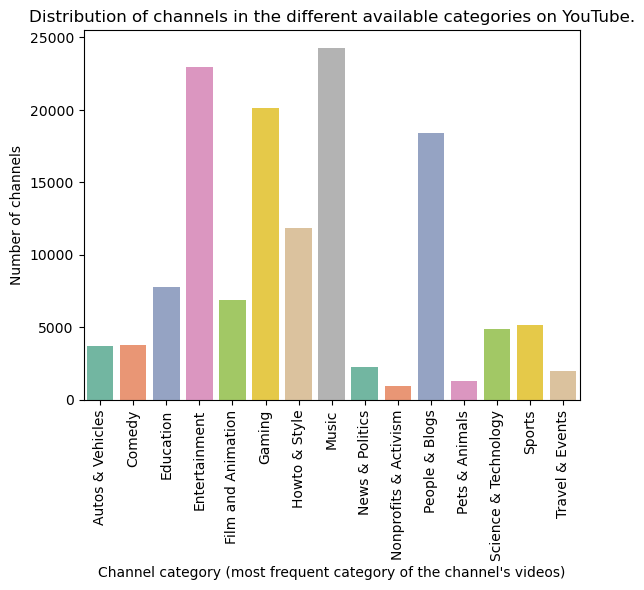

In [18]:
#distribution of categories for the channels 
category_channel= df_channels.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
display(category_channel)
category_channel.to_csv(dataset_root_path + "../generated_data/channel_count_per_category.csv")

ax = sns.barplot(x="category_cc", y="number_of_channels", data=category_channel,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of channels in the different available categories on YouTube.")
plt.xlabel("Channel category (most frequent category of the channel's videos)")
plt.ylabel("Number of channels")
plt.show()

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
2.249 secs per chunk on average. Meaning  27.301 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
2.351 secs per chunk on average. Meaning  28.500 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
2.659 secs per chunk on average. Meaning  32.190 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
2.586 secs per chunk on average. Meaning  31.261 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
2.435 secs per chunk on average. Meaning  29.396 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
2.333 secs per chunk on average. Meaning  28.123 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
2.283 secs per chunk

,category,number_of_videos
0,,1
1,Autos & Vehicles,1
2,Comedy,1
3,Education,1
4,Entertainment,1
5,Film & Animation,1
6,Gaming,1
7,Howto & Style,1
8,Movies,1
9,Music,1


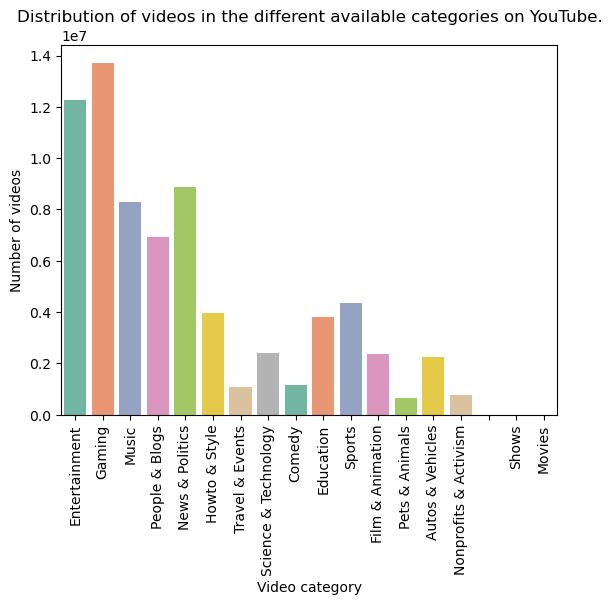

In [8]:
#distribution categories of videos over the whole dataset per chunck

# Define a function that processes a single chunk
def count_videos_by_category(chunk):
    # Count videos in each category within the chunk
    category_counts = chunk['categories'].value_counts().to_frame().T  # Get counts and transpose for one-row DataFrame
    category_counts.columns.name = None  # Remove column name for easy concatenation
    return category_counts

# Apply the function to all chunks and get the results concatenated
category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
    videos_in_chunks(chunksize=100000), 
    count_videos_by_category,
    print_time=(100000, 72924794)
)

# Sum the counts across all chunks to get the total count of videos per category
total_category_counts = category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
total_category_counts.columns = ['category', 'total_count']

total_category_counts.to_csv(dataset_root_path + "../generated_data/video_count_by_category.csv")  # save the created dataframe so we don't have to generate it again

# Display the final distribution
print(total_category_counts)

category_videos_whole_dataset= total_category_counts.groupby('category').agg(
    number_of_videos=('category', 'size')).reset_index()

display(category_videos_whole_dataset)
ax = sns.barplot(x="category", y="total_count", data=total_category_counts,hue="category", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of videos in the different available categories on YouTube.")
plt.xlabel("Video category")
plt.ylabel("Number of videos")
plt.show()

In [20]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

290


## TODO
We still need an interpretation/analysis of what we see here (in the above plots).

Something like (check this, this is just from the top of my head) "we see that there are not that many News & Politics channels compared to the other categories, however there are a much larger fraction of News & Politics *videos*. Therefore, we conclude that the News & Politics channels post videos rather actively."

Here is also an idea which Mila (I think) wrote: instead of saying it goes in our way we could say , that it is already a small category which can lead to more isolation as people are less interested 
and there exists less various sources thus clustering can happen more easily 



Is there something else which we want to analyze based on the results here which we still want to analyze?

**Also**: There seem to be videos without a category (however no channels without a category). This must be adressed, either in a general NaN filtering in the beginning (if we do that) or here. We could for instance look at what videos they are, are they all old, do they have something else in common?



## Filtering the datasets to our needs

### Filtering **videos** by category 'News & Politics'

In [ ]:
# filter the video dataframe to only include videos from n&p category

# Note: no DataFrame is created here, as it would be too big for the computer to handle 
# (too many videos are in the News & Politics category).
# Therefore, instead every 300 chunks, a compressed csv file is saved with the filtered data so far

# To actually use that data, these files will have to be loaded and used separately.

dp.run_simple_function_on_chunks_concat(videos_in_chunks(chunksize=100000),
                                        lambda x: x[x.categories == "News & Politics"], 
                                        print_time=(100000, 72924794),
                                        save=dataset_root_path + "/../generated_data/videos_in_news_pol",
                                        save_every=150,
                                        compress=".gz")

pass

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
5.327 secs per chunk on average. Meaning  64.650 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.462 secs per chunk on average. Meaning  54.088 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
4.362 secs per chunk on average. Meaning  52.797 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.849 secs per chunk on average. Meaning  46.530 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.494 secs per chunk on average. Meaning  42.175 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.268 secs per chunk on average. Meaning  39.397 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.138 secs per chunk

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
60001328,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:29.025236,If you're joining American Towman for the annu...,0.0,QThfRHnKbCw,274,0.0,"12,08,02,ATTV,Show,Saturday,720p","San Antonio ""Tow Expo International"" -- Day 2:...",2012-08-02 00:00:00,163.0
60001333,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:32.818688,There are several ways some companies steal or...,6.0,4MI_MPfl5bI,251,52.0,"poaching,youtube",The Dirty Business of Poaching Tow Calls,2012-07-03 00:00:00,13910.0
60001334,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:36.714021,A woman's story of being set on fire strikes a...,1.0,JGAkibyb8qs,192,2.0,youyube,Tow Boss Assists Woman Set on Fire in Florida,2012-06-28 00:00:00,759.0
60001335,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:40.318780,The rainy summer season in Florida can cause u...,1.0,ZjqHusNm2oA,128,4.0,"Florida,Flooding,youtube",Towman Helps Teens Stuck in Florida Flooding,2012-06-27 00:00:00,463.0
60001343,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:47.870235,Buffalo city officials are changing key towing...,0.0,6lCUY_N-PTY,140,1.0,"buffalo,youtube","Towing Policies Changed in Buffalo, NY in Resp...",2012-05-30 00:00:00,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72924789,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:02.294620,Shri Manoj Kumar Tiwari's speech during Motion...,3.0,YQLoxwLpjSU,270,67.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Manoj Kumar Tiwari's speech during Motion...,2017-02-06 00:00:00,4409.0
72924790,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:06.401481,Shri La Ganesan's speech during Motion of Than...,0.0,mINQHg1QBcg,878,21.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri La Ganesan's speech during Motion of Than...,2017-02-06 00:00:00,1172.0
72924791,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:09.530822,Shri Mukhtar Abbas Naqvi's speech during Motio...,2.0,x20aNOWh1yI,1003,35.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Mukhtar Abbas Naqvi's speech during Motio...,2017-02-06 00:00:00,1898.0
72924792,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:00.080054,BJP submitted complaint to EC against Chief Se...,0.0,-Nn6FL2gqEw,755,27.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",BJP submitted complaint to EC against Chief Se...,2017-02-06 00:00:00,726.0


In [27]:
# load the first file (corresponding to the first 150 chunks) and display
print("News & Politics videos found in the first 150 chunks of the video dataset")
df_videos_news_pol__0_149 = pd.read_csv(dataset_root_path + "/../generated_data/videos_in_news_pol__0_149.csv.gz")
display(df_videos_news_pol__0_149.head())
display(df_videos_news_pol__0_149.shape)

del df_videos_news_pol__0_149
print(gc.collect())  # collect garbage as this data (which was just loaded) is not needed anymore here

News & Politics videos found in the first 150 chunks of the video dataset


,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,1827,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,7605,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,18005,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
3,24361,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0
4,24362,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",No More Twitter? 😂,2019-10-02 00:00:00,245617.0


(1637537, 13)

0


In [32]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


### Filtering **channels** by category News & Politics

In [34]:
#filter channels dataset to only include n&p

# Note: because the channel dataset is much smaller than the video dataset, we don't need to worry about chunks here
# Also, the results can be saved in a single file without a problem.
df_channels_news_pol = df_channels[df_channels.category_cc == "News & Politics"]

df_channels_news_pol.to_csv(dataset_root_path + "../generated_data/channels_in_news_pol.csv")

In [35]:
display(df_channels_news_pol.head())
display(df_channels_news_pol.shape)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
129,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.087
133,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.087
212,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.087
268,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.087
337,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.087


(2263, 8)

## Todo:
The code below should be formalized into a function.

(something like: you give a list of files to go through, then you give it a function which it should apply to the content of each file, then in concatenates the results.
so basically like run_simple_fct_on_chunks_concat, just for separate files and not for chunks)



In [40]:
# check if all videos we found in news&pol are also pulished by a channel in category n&p

# create empty dataframe (which will later contain all videos in News & Pol which are not uploaded by a News & Pol channel)
df_videos_news_pol__channel_not_news_pol = pd.DataFrame()

# go through all of the three files we generated, containing data about videos in News&Pol
for filepath in [dataset_root_path + "/../generated_data/videos_in_news_pol__0_149.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__150_299.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__300_449.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__450_599.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__600_729.csv.gz"]:
    
    

    # using the current filepath, read the file and use it as a (temporary) df called df_videos_news_pol_i
    df_videos_news_pol_i = pd.read_csv(filepath)
    # concatenate the precious results with the results from the current file
    df_videos_news_pol__channel_not_news_pol = pd.concat(
        [df_videos_news_pol__channel_not_news_pol, 
         df_videos_news_pol_i[
             np.logical_not(df_videos_news_pol_i.channel_id.isin(df_channels_news_pol.channel))]
             ])
    del df_videos_news_pol_i
    print(f"gc {gc.collect()}")
        
display(df_videos_news_pol__channel_not_news_pol.head())
display(df_videos_news_pol__channel_not_news_pol.shape)

df_videos_news_pol__channel_not_news_pol.to_csv(dataset_root_path + "../generated_data/videos_in_news_pol__channel_not_in_news_pol.csv")
        



gc 1769
gc 0
gc 0
gc 0
gc 0


,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,1827,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,"RetroGamer3,Live Stream,politics,Trump",Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,7605,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,"NWO,Ebola,Ukraine,Mainstream,Media,Pyschology",Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,18005,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media:\n\nFacebook.com/thebookoflaura\n...,89.0,eWXefhNB2po,707,625.0,"michael jackson,lyrics,music video,court,child...",my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
1035,28840,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:01.617657,A young man is living a normal life with no ca...,16.0,ck6Yl8TNoWs,1257,452.0,"JoiRida,Cheatham,JoiRidaCheatham,Accepted,Detr...",Accepted - Award Winning Short Film,2013-10-13 00:00:00,27366.0
1036,28860,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:06.565138,Short Film,1.0,tjUajxZAIZ8,422,15.0,"Joi.Rida,Cheatham,joiridacheatham,dread,loc,up...",JoiRida Twin Visit (Introducing Jive Viper),2010-03-04 00:00:00,987.0


(619635, 13)

**We see that indeed, not all videos in the news and politics category belong to a channel in this category!**
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channe, but not all.

In the paper about the dataset, the authors say that the channel category is actually the "most frequent category", so I guess the video categories are the most relevant, as they are the true categories.

We could try to verify this, if we want to.

In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

31


### Filtering the N&P videos by a list of channels

## Todo:
when the function to run stuff on several files and concatenate (see previous todo) is done, the below code should be rewritten to use that fct

In [5]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, ABC News, BBC News, Al Jazeera English and Fox News)

# create empty dataframe (which will later contain all videos in News & Pol which are not uploaded by a News & Pol channel)
df_videos_news_pol_manually_selected = pd.DataFrame()

# go through all of the three files we generated, containing data about videos in News&Pol
for filepath in [dataset_root_path + "/../generated_data/videos_in_news_pol__0_149.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__150_299.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__300_449.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__450_599.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__600_729.csv.gz"]:

    # using the current filepath, read the file and use it as a (temporary) df called df_videos_news_pol
    df_videos_news_pol_i = pd.read_csv(filepath)
    # concatenate the precious results with the results from the current file
    df_videos_news_pol_manually_selected = pd.concat([df_videos_news_pol_manually_selected,
          df_videos_news_pol_i[df_videos_news_pol_i.channel_id.isin(["UCupvZG-5ko_eiXAupbDfxWw",  # CNN
                                                                     "UCBi2mrWuNuyYy4gbM6fU18Q",  # ABC News
                                                                     "UC16niRr50-MSBwiO3YDb3RA",  # BBC News
                                                                     "UCNye-wNBqNL5ZzHSJj3l8Bg",  # Al Jazeera English
                                                                     "UCXIJgqnII2ZOINSWNOGFThA",  # Fox News
                                                              ])]
                                                              ])
    del df_videos_news_pol_i
    print(f"gc {gc.collect()}")
        
display(df_videos_news_pol_manually_selected.head())
display(df_videos_news_pol_manually_selected.shape)

df_videos_news_pol_manually_selected.to_csv(dataset_root_path + "../generated_data/videos_from_news_pol_from_selected_channels.csv")

gc 491
gc 0
gc 0
gc 0
gc 0


,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
1456651,26952027,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:52.312339,God's not Dead' now available on DVD\nWatch th...,3.0,Tu8LeamtOmc,252,6.0,"Fox Friends,Clayton Morris,Famous Faces,Faith,...",'Duck Dynasty' stars talk faith in entertainment,2014-12-29 00:00:00,344.0
1456652,26952028,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:55.983188,Shocking new tape reveals 15-year-old woman di...,2.0,a9RXcMkahu8,347,11.0,"Bill Oreilly,Oreilly Factor,Personal Freedoms,...",Planned Parenthood Controversy,2014-12-29 00:00:00,1057.0
1456653,26952029,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:26:01.107518,"Watters asks the folks of Cambridge, Massachus...",89.0,KrQu5grf5v8,277,1958.0,"Oreilly Factor,Bill Oreilly,Jesse Watters,Watt...",Watters' World: Free stuff edition,2014-12-29 00:00:00,244169.0
1456654,26952030,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:26:07.440358,New Pew poll shows 44 percent say they are not...,6.0,CVzmKWI2OXQ,283,12.0,"Bill Oreilly,Charles Krauthammer,Oreilly Facto...",What happened to patriotism?,2014-12-29 00:00:00,798.0
1456655,26952031,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:50.948588,Jesse Watters ventures into the National Organ...,12.0,J9A7_Gjjzzg,294,448.0,"Oreilly Factor,Bill Oreilly,Jesse Watters,Watt...",Watters' World: NOW edition,2014-12-29 00:00:00,43412.0


(164129, 13)

### Doing our own ranking of N&P channels (not necessary)

We don't have to do an analysis of channel popularity to justify our choice of channels.

We could however do some simple thing like showing where they are on the ranking in the dataset (as the statistic we used is from 2024 (I guess) and the dataset is older)

### Todo?? 

In [ ]:
# sort the previously filtered n&p channels by subscriber count according to channel crawler
#df_channels_news_pol_sort_subscribers = df_channels_news_pol.sort_values(by="subscribers_cc", ascending=False)

In [ ]:
#display(df_channels_news_pol_sort_subscribers)

### Filtering news & pol **videos** in a specific channel

In [6]:
# filter the video dataset to get only videos from a specific channel (here: CNN, as an example)

df_videos_news_pol_cnn = df_videos_news_pol_manually_selected.loc[
    df_videos_news_pol_manually_selected.channel_id == "UCupvZG-5ko_eiXAupbDfxWw"]

df_videos_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/videos_news_pol_cnn.csv")

# below is old code, which actually goes through the complete video dataset (in chunks) 
# to find the videos from a specific channel.
# This is not necessary, as the only benefit is that we get videos from any cateory, but we are actually 
# only interested in News & Pol videos

# videos_from_channel_test = dp.run_simple_function_on_chunks_concat(
#     videos_in_chunks(chunksize=100000),
#     lambda x: x.loc[x.channel_id == "UCzWrhkg9eK5I8Bm3HfV-unA"],
#     print_time=(100000, 72924794))

# videos_from_channel_test.to_csv("../data/videos_from_channel_UCzWrhkg9eK5I8Bm3HfV-unA_test.csv")

### Filtering **comments** from news & pol videos in a specific channel

This second function probably needs to look like this, as we haven't preprocessed the comment data yet, so it is still too big to be considered all at once, so we need the chunks.

## Todo:
probably (possibly?), we will also have to filter for NaN and empty values here.
Unless we already did that earlier.

In [7]:
# get comments on (n&p) videos from a specific channel (here: CNN) using the ids from filtered video dataset

df_comments_news_pol_cnn = dp.run_simple_function_on_chunks_concat(
    comments_in_chunks(chunksize=1000000), 
    lambda df: df[df.video_id.isin(df_videos_news_pol_cnn.display_id)],
    print_time=(1000000, 8600000000))

df_comments_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/comments_news_pol_cnn.csv")

NameError: name 'comments_in_chunks' is not defined

In [ ]:
display(df_comments_news_pol_cnn.head())
display(df_comments_news_pol_cnn.shape)

,author,video_id,likes,replies
6868268,453667,3vQK78eUg2A,2,1
7094579,468696,SWZG-ba1qDk,15,18
8912192,594074,hn2zYwqSINY,0,1


### Plots 
1. Using the previous functions, plot the tot nb of comments and/or subscribers in the selected channels (all on same plot).

2. For each channel, plot the distribution of comments for all the users.

## Selecting the cluster of users in a specific channel 

(flexible function where you give the threshold of x comments)


In [ ]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_data: pd.DataFrame, threshold: int = 0) -> pd.DataFrame:
    """
    Generates a dataframe with comment count and number of videos commented under, 
    for each person that has commented.
    Works on any df containing a set of comment data 
    (e.g., filtered to contain only comments under videos from a certain channel).

    Args:
        comment_data: df containing the comments for which to generate metadata
        threshold: (default 0) only commenters with more than this amount of comments 
            will be included in the dataframe.

    Returns:
        df with columns author, number of comments and number of videos
    """

    metadata_commenters = comment_data.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_data.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than <threshold> comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=threshold]
    return metadata_commenters

#test with threshold=0
metadata_commenters_news_pol_cnn = get_metadata_commenters(df_comments_news_pol_cnn,0)

metadata_commenters_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn.csv")

display(metadata_commenters_news_pol_cnn.head())
display(metadata_commenters_news_pol_cnn.shape)

,author,number_of_comments,number_of_videos
0,453667,1,1
1,468696,1,1
2,594074,1,1


### Plots
1. Venn diagram with clusters of the channels and underline overlaps

# Deeper analysis and statistics
Todo: 
create dataset of all comments which are under a video in the news and politics category

use this dataset to get the list of videos under which each of the users we found (above) have made a comment

for each pair of users, calculate "number of videos in common (under which both have commented) / min number of videos both users have commented on"
(example: mila commented on 10 videos, andreas on 100 videos, they have 8 videos they both commented on, so the value we calculate is 8/10 = 0.8)
